In [19]:
import numpy as np 
from math import pi
import sympy as sy
import matplotlib.pyplot as plt 
from numba import jit
from sklearn.model_selection import train_test_split

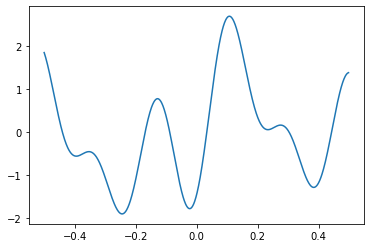

In [20]:
# general random sample 

seed = 2022
np.random.seed(seed)
N = 512
x = np.random.uniform(-pi,pi,2*N)
x.sort()
b1,b2,b3 = np.random.uniform(0,2*pi,3)
y = np.sin(x) + np.sin(10*x+b1) + np.sin(20*x+b2) + np.sin(30*x+b3)

# split the data 
# x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.5)
# print(len(x_tr))
# x_ts, y_ts = zip(*sorted(zip(x_ts, y_ts)))

# grid sample
N0 = 1000
dx = 0.001
x0 = np.linspace(-N0/2*dx, (N0/2-1)*dx, N0, endpoint=False)
x0.sort()
y0 = np.sin(x0) + np.sin(10*x0+b1) + np.sin(20*x0+b2) + np.sin(30*x0+b3)

# plt.plot(x_ts,y_ts)
# plt.show()
plt.plot(x0, y0)
plt.show()

In [21]:
# define the function includes w0

d = 1
px = 1/2/pi
fp = np.sqrt(px) * (y - np.mean(y))
# print(fp)

@jit(nopython=True)
def f_approx(w0):
    f = 0
    for i in range(N-1):
        for j in range(N-1): 
            sinc = 1
            if d == 1: 
                K = [1]
            else: 
                K = range(1,d)
            for k in K: 
                t = w0*(x[j]**k - x[i]**k)
                if t == 0: 
                    sinc = sinc * 1
                else: 
                    sinc = sinc * np.sin(t) / t
            f = f + fp[i]*fp[j]/(px*px) * (w0/pi)**d * sinc 
    f = f * 2 / (N**2)
    return f      

# print(f_approx(10))

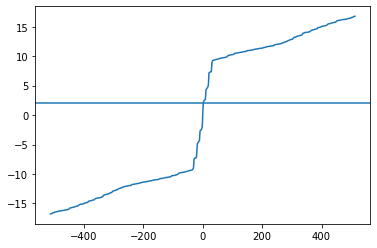

In [22]:
W = np.linspace(-N, N, 2*N+1)
# print(W)
f_w = np.zeros(2*N+1)

for w in W: 
    i = w + N
    i = int(i)
    f_w[i] = f_approx(w)
# print(f_w)

y_var = np.var(y)
# print(y_var)

plt.plot(W, f_w)
plt.axhline(y = y_var)
plt.show()

In [23]:
# compute the cut-off w0

# w0 = sy.symbols('w0')
# print(sy.solve(f_approx(w0)-np.var(y),w0))

f_abs = np.abs(f_w-y_var)

f_min = min(f_abs)
print(f_min)

w0 = np.argmin(f_abs) - N
print(w0)

0.060070993721154764
2


In [24]:
# training the function with NN  

import tensorflow as tf 
from tensorflow import keras 

In [25]:
# define the keras model 
K = 64
input_layer = keras.Input(shape = (1, ))
hidden_layer_1 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_2 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_3 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_4 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_5 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
output_layer = keras.layers.Dense(units = 1, 
                                    use_bias = False)
model = keras.Sequential([input_layer, hidden_layer_1,
                          hidden_layer_2, hidden_layer_3, 
                          hidden_layer_4, hidden_layer_5, 
                          output_layer])

# compling the model 
adam = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer = 'adam', loss = 'mse')

In [26]:
def NN_epoch(n_epoch):
    # fitting the data 
    tf.random.set_seed(seed)
    beta = model.fit(x0, y0, epochs=n_epoch, batch_size=32)

    # predicting the data
    predict_1 = model.predict(x0)

    # compute r
    predict_1 = predict_1.reshape(N0)
    r = y0 - predict_1

    plt.plot(x0, y0, color='black')
    plt.plot(x0, predict_1, color='g')
    plt.plot(x0, r, color='r')
    plt.show()


    # calculate r_p
    px = 1/2/pi
    rp = np.sqrt(px) * (r - np.mean(r))

    # compute sum_low

    e_low = 0
    for i in range(N0-1):
        for j in range(N0-1): 
            sinc = 1
            if d == 1: 
                K = [1]
            else: 
                K = range(1,d)
            for k in K: 
                t = w0*(x0[j]**k - x0[i]**k)
                if t == 0: 
                    sinc = sinc * 1
                else: 
                    sinc = sinc * np.sin(t) / t
            e_low = e_low + rp[i]*rp[j]/px/px * (w0 **d / pi**d) * sinc 
    e_low = e_low / (N0**2) / y_var
    print(e_low)

    # compute SB
    var_r = np.var(r)
    var_f = np.var(y)
    FVU = var_r/var_f 
    print(FVU)
    SB = (FVU-2*e_low)/FVU
    print(SB)

Epoch 1/20
32/32 [==============================] - 0s 783us/step - loss: 1.3727
Epoch 2/20
32/32 [==============================] - 0s 788us/step - loss: 1.3429
Epoch 3/20
32/32 [==============================] - 0s 950us/step - loss: 1.3492
Epoch 4/20
32/32 [==============================] - 0s 974us/step - loss: 1.3476
Epoch 5/20
32/32 [==============================] - 0s 976us/step - loss: 1.3594
Epoch 6/20
32/32 [==============================] - 0s 928us/step - loss: 1.3622
Epoch 7/20
32/32 [==============================] - 0s 807us/step - loss: 1.3504
Epoch 8/20
32/32 [==============================] - 0s 781us/step - loss: 1.3450
Epoch 9/20
32/32 [==============================] - 0s 710us/step - loss: 1.3494
Epoch 10/20
32/32 [==============================] - 0s 764us/step - loss: 1.3605
Epoch 11/20
32/32 [==============================] - 0s 744us/step - loss: 1.3621
Epoch 12/20
32/32 [==============================] - 0s 767us/step - loss: 1.3453
Epoch 13/20
32/32 [======

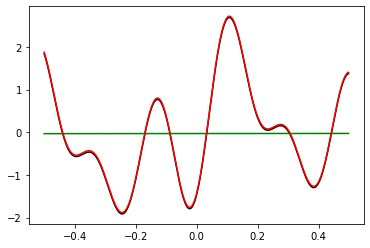

0.008502033459466629
0.6661781819807822
0.9744751969084694


In [27]:
NN_epoch(20)